In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)

In [2]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 10)
    max_depth = trial.suggest_int('max_depth', 1000, 3000)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                      max_features=max_features, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize') 
improvement_threshold = 0.001
stale_count = 0

best_mse = float('inf')

mse_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value < best_mse:
        best_mse = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    mse_values.append(best_mse)

    if stale_count >= 11000 or best_mse <= improvement_threshold:  
        break

best_params = study.best_params
best_mse = study.best_value

print("Best Parameters:", best_params)
print("Best Mean Squared Error:", best_mse)



[I 2023-11-24 09:30:37,286] A new study created in memory with name: no-name-073ad350-033f-495b-b81a-0da4f1a84f7e
[I 2023-11-24 09:30:37,320] Trial 0 finished with value: 203.66009652208766 and parameters: {'n_estimators': 3, 'max_depth': 2415, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.16498685986394201}. Best is trial 0 with value: 203.66009652208766.
[I 2023-11-24 09:30:37,382] Trial 1 finished with value: 190.90545023333212 and parameters: {'n_estimators': 4, 'max_depth': 1476, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': 0.88303153577939}. Best is trial 1 with value: 190.90545023333212.
[I 2023-11-24 09:30:37,419] Trial 2 finished with value: 198.2741145190854 and parameters: {'n_estimators': 5, 'max_depth': 2878, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 0.14909087394710635}. Best is trial 1 with value: 190.90545023333212.
[I 2023-11-24 09:30:37,605] Trial 3 finished with value: 217.93425157293098 and parameters: {'n

Best Parameters: {'n_estimators': 6, 'max_depth': 1910, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.41133356102152946}
Best Mean Squared Error: 184.530279285807


Średni błąd kwadratowy (MSE): 184.530279285807
Procentowa zgodność: -13.50%


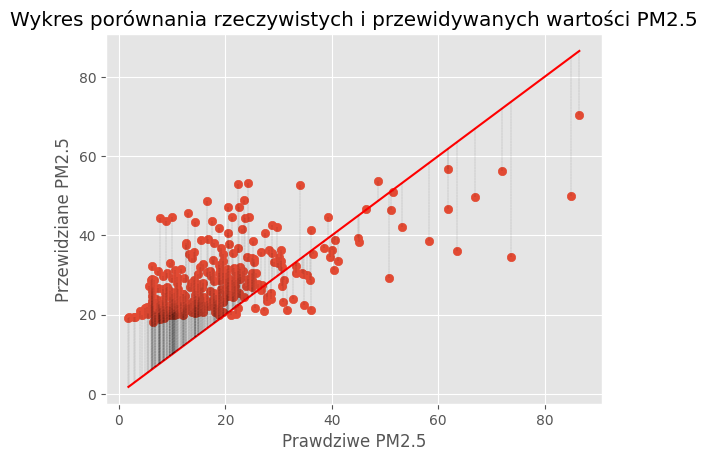

Średni błąd kwadratowy (MSE): 95.19537686154632
r2 score: -161.54%


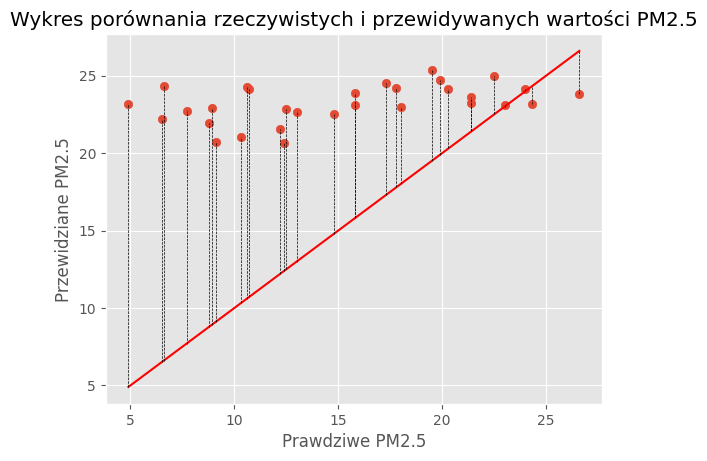

In [7]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


model = GradientBoostingRegressor(**best_params,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']

y_pred_test = model.predict(X_test_test)
mse = mean_squared_error(y_test_test, y_pred_test)
r2 = r2_score(y_test_test, y_pred_test)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)], 'r', label='y=x')
plt.scatter(y_test_test, y_pred_test)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()


In [8]:

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test_test, 'Przewidywane wartości (y_pred)': y_pred_test})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results


Rzeczywiste wartości (y_test)  Przewidywane wartości (y_pred)    Różnica
0                             9.1                       20.692772 -11.592772
1                            10.3                       21.045278 -10.745278
2                            12.4                       20.663150  -8.263150
3                            12.5                       22.878142 -10.378142
4                            15.8                       23.088986  -7.288986
5                            17.8                       24.189204  -6.389204
6                            23.0                       23.125976  -0.125976
7                            21.4                       23.239322  -1.839322
8                            24.0                       24.153710  -0.153710
9                            22.5                       24.983797  -2.483797
10                           20.3                       24.150541  -3.850541
11                           26.6                       23.804517   2.795483
12                           24.3                       23.165523   1.134477
13                            8.9                       22.919547 -14.019547
14                            6.5                       22.233881 -15.733881
15                           15.8                       23.889756  -8.089756
16                           10.7                       24.124918 -13.424918
17                           13.0                       22.634614  -9.634614
18                            8.8                       21.975271 -13.175271
19                            6.6                       24.311662 -17.711662
20                           10.6                       24.289147 -13.689147
21                           14.8                       22.528527  -7.728527
22                            7.7                       22.703114 -15.003114
23                            4.9                       23.185284 -18.285284
24                           12.2                       21.534139  -9.334139
25                           17.3                       24.515615  -7.215615
26                           19.9                       24.706804  -4.806804
27                           19.5                       25.354155  -5.854155
28                           21.4                       23.609680  -2.209680
29                           18.0                       22.963948  -4.963948

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)

In [10]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 10)
    max_depth = trial.suggest_int('max_depth', 1000, 3000)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                      max_features=max_features, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize') 
improvement_threshold = 0.001
stale_count = 0

best_mse = float('inf')

mse_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value < best_mse:
        best_mse = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    mse_values.append(best_mse)

    if stale_count >= 11000 or best_mse <= improvement_threshold:  
        break

best_params = study.best_params
best_mse = study.best_value

print("Best Parameters:", best_params)
print("Best Mean Squared Error:", best_mse)



[I 2023-11-24 11:05:19,106] A new study created in memory with name: no-name-2be7c0b4-8a5e-4130-8bd4-e82b98688d5c
[I 2023-11-24 11:05:19,156] Trial 0 finished with value: 462.35467655263034 and parameters: {'n_estimators': 3, 'max_depth': 1999, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 0.726627173326339}. Best is trial 0 with value: 462.35467655263034.
[I 2023-11-24 11:05:19,169] Trial 1 finished with value: 569.5798733413723 and parameters: {'n_estimators': 2, 'max_depth': 1823, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 0.13813682885016196}. Best is trial 0 with value: 462.35467655263034.
[I 2023-11-24 11:05:19,283] Trial 2 finished with value: 228.9561276797625 and parameters: {'n_estimators': 9, 'max_depth': 1304, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 0.9846484689203607}. Best is trial 2 with value: 228.9561276797625.
[I 2023-11-24 11:05:19,343] Trial 3 finished with value: 274.6565590592999 and parameters: {'n

Best Parameters: {'n_estimators': 10, 'max_depth': 2173, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.378010694518095}
Best Mean Squared Error: 109.38152317699688


Średni błąd kwadratowy (MSE): 109.38152317699688
Procentowa zgodność: 82.64%


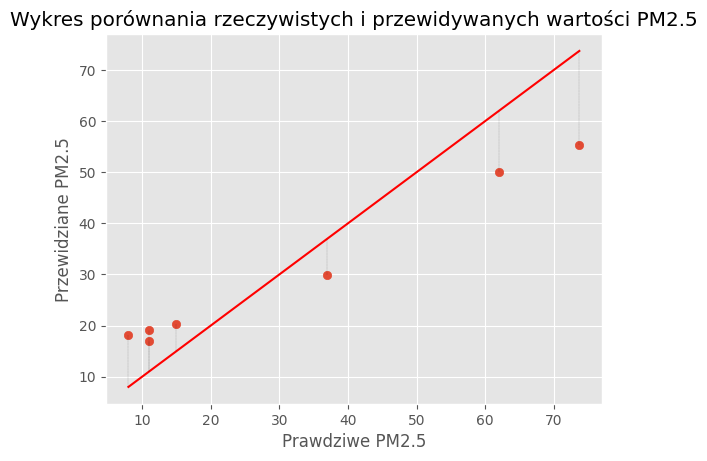

Średni błąd kwadratowy (MSE): 69.49137834225694
r2 score: -90.92%


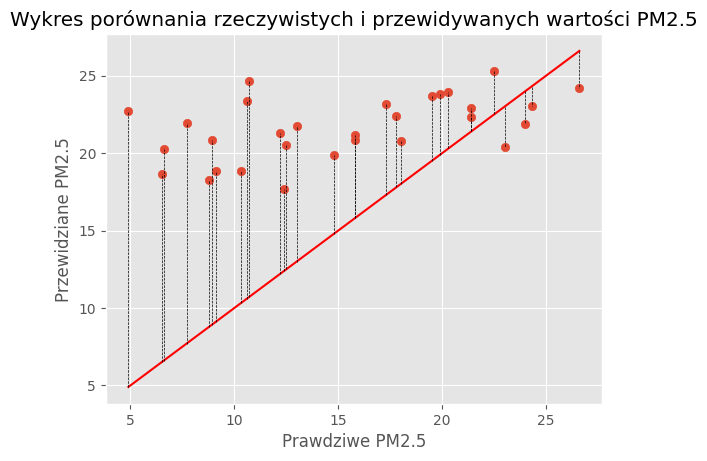

In [11]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


model = GradientBoostingRegressor(**best_params,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']

y_pred_test = model.predict(X_test_test)
mse = mean_squared_error(y_test_test, y_pred_test)
r2 = r2_score(y_test_test, y_pred_test)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)], 'r', label='y=x')
plt.scatter(y_test_test, y_pred_test)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()


In [12]:

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test_test, 'Przewidywane wartości (y_pred)': y_pred_test})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results


Rzeczywiste wartości (y_test)  Przewidywane wartości (y_pred)    Różnica
0                             9.1                       18.842334  -9.742334
1                            10.3                       18.852323  -8.552323
2                            12.4                       17.655086  -5.255086
3                            12.5                       20.496490  -7.996490
4                            15.8                       21.155771  -5.355771
5                            17.8                       22.389783  -4.589783
6                            23.0                       20.401540   2.598460
7                            21.4                       22.308814  -0.908814
8                            24.0                       21.904222   2.095778
9                            22.5                       25.320418  -2.820418
10                           20.3                       23.940212  -3.640212
11                           26.6                       24.188157   2.411843
12                           24.3                       23.031697   1.268303
13                            8.9                       20.851744 -11.951744
14                            6.5                       18.680560 -12.180560
15                           15.8                       20.850439  -5.050439
16                           10.7                       24.639716 -13.939716
17                           13.0                       21.756975  -8.756975
18                            8.8                       18.232888  -9.432888
19                            6.6                       20.283008 -13.683008
20                           10.6                       23.388643 -12.788643
21                           14.8                       19.897558  -5.097558
22                            7.7                       21.956622 -14.256622
23                            4.9                       22.731229 -17.831229
24                           12.2                       21.295052  -9.095052
25                           17.3                       23.173987  -5.873987
26                           19.9                       23.787088  -3.887088
27                           19.5                       23.720917  -4.220917
28                           21.4                       22.885936  -1.485936
29                           18.0                       20.785109  -2.785109

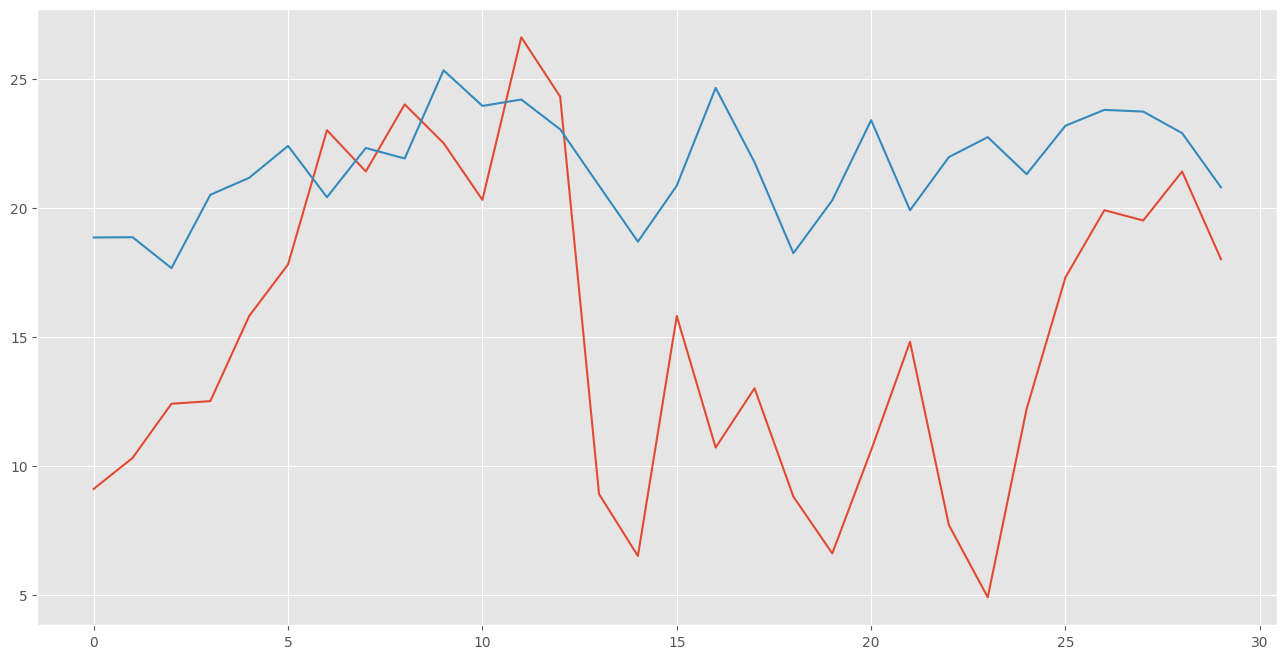

In [13]:
plt.figure(figsize=[16,8])
plt.plot(y_test_test)
plt.plot(y_pred_test)
plt.show()